# Installs and imports

In [1]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 12.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=91b9fd1657955ddc79f71c4a2326ac26f98f333f5ac0fbdfd239eedcf5aeccd0
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle as pkl

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch_geometric.data import Dataset, DataLoader, Data
from torch_geometric.nn import GraphConv
from torch_geometric.utils import to_undirected

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Utils

### Plotting

In [4]:
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

def plot_hexbin(targ, pred, title="", scale="linear",
                inc_factor = 1.1, dec_factor = 0.9,
                bins=None, plot_helper_lines=False,
                cmap='viridis',lims=None):

    fig, ax = plt.subplots(figsize=(6,6))

    mae = mean_absolute_error(targ, pred)
    r, _ = pearsonr(targ, pred)

    if scale == 'log':
        pred = np.abs(pred) + 1e-8
        targ = np.abs(targ) + 1e-8

    lim_min = min(np.min(pred), np.min(targ))
    if lim_min < 0:
        if lim_min > -0.1:
            lim_min = -0.1
        lim_min *= inc_factor
    else:
        if lim_min < 0.1:
            lim_min = -0.1
        lim_min *= dec_factor
    lim_max = max(np.max(pred), np.max(targ))
    if lim_max <= 0:
        if lim_max > -0.1:
            lim_max = 0.2
        lim_max *= dec_factor
    else:
        if lim_max < 0.1:
            lim_max = 0.25
        lim_max *= inc_factor

    if lims:
        lim_min = lims[0]
        lim_max = lims[1]

#     ax.set_xlim(0.8, 1.05)
#     ax.set_ylim(0.8, 1.05)
    ax.set_aspect('equal')

    #ax.plot((lim_min, lim_max),
    #        (lim_min, lim_max),
    #        color='#000000',
    #        zorder=-1,
    #        linewidth=0.5)
    ax.axline((0, 0), (1, 1),
           color='#000000',
           zorder=-1,
           linewidth=0.5)

    hb = ax.hexbin(
        targ, pred,
        cmap=cmap,
        gridsize=60,
        bins=bins,
        mincnt=1,
        edgecolors=None,
        linewidths=(0.1,),
        xscale=scale,
        yscale=scale,
        extent=(lim_min, lim_max, lim_min, lim_max))


    cb = fig.colorbar(hb, shrink=0.822)
    cb.set_label('Count')

    if plot_helper_lines:

        if scale == 'linear':
            x = np.linspace(lim_min, lim_max, 50)
            y_up = x + mae
            y_down = x - mae

        elif scale == 'log':
            x = np.logspace(np.log10(lim_min), np.log10(lim_max), 50)

            # one order of magnitude
            y_up = np.maximum(x + 1e-2, x * 10)
            y_down = np.minimum(np.maximum(1e-8, x - 1e-2), x / 10)

            # one kcal/mol/Angs
            y_up = x + 1
            y_down = np.maximum(1e-8, x - 1)


        for y in [y_up, y_down]:
            ax.plot(x,
                    y,
                    color='#000000',
                    zorder=2,
                    linewidth=0.5,
                    linestyle='--')

    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Predicted order parameters', fontsize=12)
    ax.set_xlabel('Experimental order parameters', fontsize=12)

    ax.annotate("Pearson's r: %.3f \nMAE: %.3f" % (r, mae),
                (0.03, 0.88),
                xycoords='axes fraction',
                fontsize=12)

    return r, mae, ax, hb

### EGNN Code

In [5]:
class E_GCL(nn.Module):
    """
    E(n) Equivariant Convolutional Layer
    re
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, act_fn=nn.SiLU(), residual=True, attention=False, normalize=False, coords_agg='mean', tanh=False):
        super(E_GCL, self).__init__()
        input_edge = input_nf * 2
        self.residual = residual
        self.attention = attention
        self.normalize = normalize
        self.coords_agg = coords_agg
        self.tanh = tanh
        self.epsilon = 1e-8
        edge_coords_nf = 1

        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edge_coords_nf + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        coord_mlp = []
        coord_mlp.append(nn.Linear(hidden_nf, hidden_nf))
        coord_mlp.append(act_fn)
        coord_mlp.append(layer)
        if self.tanh:
            coord_mlp.append(nn.Tanh())
        self.coord_mlp = nn.Sequential(*coord_mlp)

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

    def edge_model(self, source, target, radial, edge_attr):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target, radial], dim=1)
        else:
            out = torch.cat([source, target, radial, edge_attr], dim=1)
        out = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(out)
            out = out * att_val
        return out

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        if self.residual:
            out = x + out
        return out, agg

    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        if self.coords_agg == 'sum':
            agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
        elif self.coords_agg == 'mean':
            agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        else:
            raise Exception('Wrong coords_agg parameter' % self.coords_agg)
        coord = coord + agg
        return coord

    def coord2radial(self, edge_index, coord):
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum(coord_diff**2, 1).unsqueeze(1)

        if self.normalize:
            norm = torch.sqrt(radial).detach() + self.epsilon
            coord_diff = coord_diff / norm

        return radial, coord_diff

    def forward(self, h, edge_index, coord, edge_attr=None, node_attr=None):
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)

        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)

        return h, coord, edge_attr


class EGNN(nn.Module):
    def __init__(self, in_node_nf, hidden_nf, out_node_nf, in_edge_nf=0, device='cpu', act_fn=nn.SiLU(), n_layers=4, residual=True, attention=False, normalize=False, tanh=False):
        '''

        :param in_node_nf: Number of features for 'h' at the input
        :param hidden_nf: Number of hidden features
        :param out_node_nf: Number of features for 'h' at the output
        :param in_edge_nf: Number of features for the edge features
        :param device: Device (e.g. 'cpu', 'cuda:0',...)
        :param act_fn: Non-linearity
        :param n_layers: Number of layer for the EGNN
        :param residual: Use residual connections, we recommend not changing this one
        :param attention: Whether using attention or not
        :param normalize: Normalizes the coordinates messages such that:
                    instead of: x^{l+1}_i = x^{l}_i + Σ(x_i - x_j)phi_x(m_ij)
                    we get:     x^{l+1}_i = x^{l}_i + Σ(x_i - x_j)phi_x(m_ij)/||x_i - x_j||
                    We noticed it may help in the stability or generalization in some future works.
                    We didn't use it in our paper.
        :param tanh: Sets a tanh activation function at the output of phi_x(m_ij). I.e. it bounds the output of
                        phi_x(m_ij) which definitely improves in stability but it may decrease in accuracy.
                        We didn't use it in our paper.
        '''

        super(EGNN, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        self.embedding_in = nn.Linear(in_node_nf, self.hidden_nf)
        self.embedding_out = nn.Linear(self.hidden_nf, out_node_nf)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, E_GCL(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=in_edge_nf,
                                                act_fn=act_fn, residual=residual, attention=attention,
                                                normalize=normalize, tanh=tanh))
        self.to(self.device)

    def forward(self, h, x, edges, edge_attr):
        h = self.embedding_in(h)
        for i in range(0, self.n_layers):
            h, x, _ = self._modules["gcl_%d" % i](h, edges, x, edge_attr=edge_attr)
        h = self.embedding_out(h)
        return h, x


def unsorted_segment_sum(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result


def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)


def get_edges(n_nodes):
    rows, cols = [], []
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                rows.append(i)
                cols.append(j)

    edges = [rows, cols]
    return edges


def get_edges_batch(n_nodes, batch_size):
    edges = get_edges(n_nodes)
    edge_attr = torch.ones(len(edges[0]) * batch_size, 1)
    edges = [torch.LongTensor(edges[0]), torch.LongTensor(edges[1])]
    if batch_size == 1:
        return edges, edge_attr
    elif batch_size > 1:
        rows, cols = [], []
        for i in range(batch_size):
            rows.append(edges[0] + n_nodes * i)
            cols.append(edges[1] + n_nodes * i)
        edges = [torch.cat(rows), torch.cat(cols)]
    return edges, edge_attr

# Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
pdb_graphs = pkl.load(open('/content/drive/MyDrive/pdb_graphs.pkl', 'rb'))

In [9]:
err_ids = []
for i,entry in pdb_graphs.items():
  if len(entry[0]) != len(entry[3]):
    err_ids.append(i)

In [10]:
print(len(pdb_graphs))
pdb_graphs = {k:v for k,v in pdb_graphs.items() if k not in err_ids}
print(len(pdb_graphs))

940
924


In [11]:
node_features = [entry[0] for entry in pdb_graphs.values()]
coords = [entry[1] for entry in pdb_graphs.values()]
edge_indices = [entry[2] for entry in pdb_graphs.values()]

In [12]:
labels = [entry[3] for entry in pdb_graphs.values()]
labels = [torch.min(l,torch.tensor([1.1])) for l in labels]
labels = [torch.max(l,torch.tensor([-1])) for l in labels]

In [17]:
(node_train, node_test, \
 coord_train, coord_test, \
 edge_train, edge_test, \
 y_train, y_test) = train_test_split(
                                      node_features,
                                      coords,
                                      edge_indices,
                                      labels,
                                      test_size = 0.2,
                                      random_state = 0
                                      )

In [18]:
# (node_train, node_val, \
#  coord_train, coord_val, \
#  edge_train, edge_val, \
#  y_train, y_val) = train_test_split(
#                                       node_train,
#                                       coord_train,
#                                       edge_train,
#                                       y_train,
#                                       test_size = 0.2,
#                                       random_state = 0
#                                       )

In [19]:
# Scaler for node features that are not one-hots
scaler = ColumnTransformer(
     [("scaler", StandardScaler(), slice(20, 34))],
     remainder='passthrough')
# Fit scaler to training data
scaler.fit(torch.concatenate(node_train))
# Apply scalar to all splits
node_train = [scaler.transform(entry) for entry in node_train]
# node_val = [scaler.transform(entry) for entry in node_val]
node_test = [scaler.transform(entry) for entry in node_test]

# Models

## Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
lr_x_train = np.concatenate(node_train)
lr_x_test = np.concatenate(node_test)

lr_y_train = np.concatenate(y_train)
lr_y_test = np.concatenate(y_test)

In [22]:
lr = LinearRegression()
lr.fit(lr_x_train, lr_y_train)

LinearRegression()

In [23]:
lr_train_preds = lr.predict(lr_x_train)
lr_test_preds = lr.predict(lr_x_test)
print("Train:",lr.score(lr_x_train, lr_y_train))
print("Test:",lr.score(lr_x_test, lr_y_test))

Train: 0.18047308508164972
Test: 0.1795147393252945


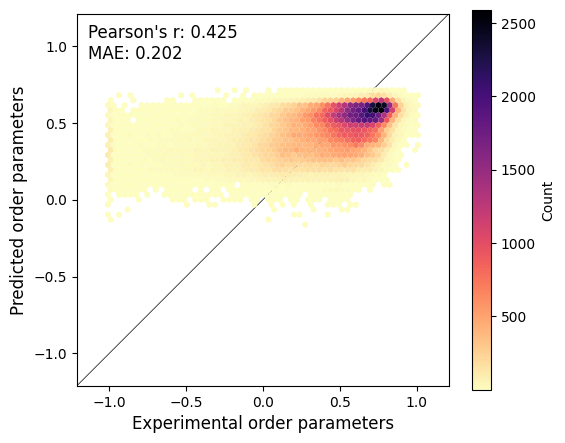

In [24]:
r, mae, ax, hb = plot_hexbin(lr_y_train, lr_train_preds, cmap='magma_r')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

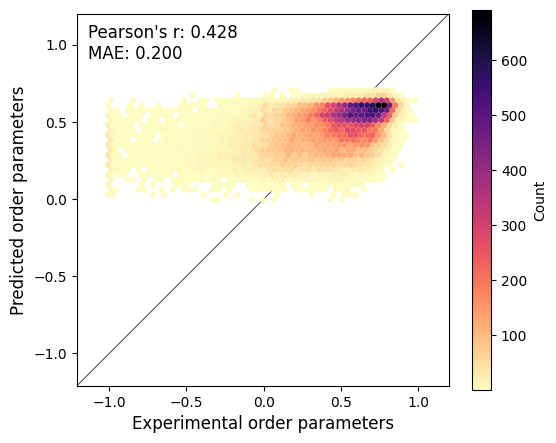

In [26]:
r, mae, ax, hb = plot_hexbin(lr_y_test, lr_test_preds, cmap='magma_r')
ax.figure.savefig("LR.png",bbox_inches="tight")
from google.colab import files
files.download("LR.png")

## Random Forest

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [65]:
rf_x_train = np.concatenate(node_train)
rf_x_test = np.concatenate(node_test)

rf_y_train = np.concatenate(y_train)
rf_y_test = np.concatenate(y_test)

In [66]:
rf = RandomForestRegressor(random_state=0, max_depth=15)
rf.fit(rf_x_train, rf_y_train)

RandomForestRegressor(max_depth=15, random_state=0)

In [67]:
rf_train_preds = rf.predict(rf_x_train)
rf_test_preds = rf.predict(rf_x_test)
print("Train:",rf.score(rf_x_train, rf_y_train))
print("Test:",rf.score(rf_x_test, rf_y_test))

Train: 0.3268781229476805
Test: 0.2441564027080263


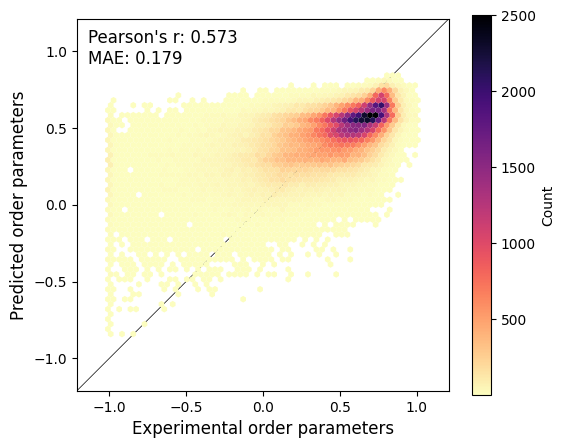

In [68]:
r, mae, ax, hb = plot_hexbin(rf_y_train, rf_train_preds, cmap='magma_r')

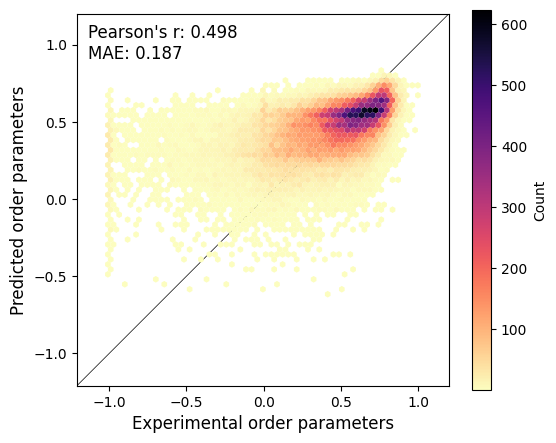

In [69]:
r, mae, ax, hb = plot_hexbin(rf_y_test, rf_test_preds, cmap='magma_r')
# ax.figure.savefig("RF.png",bbox_inches="tight")
# files.download("RF.png")

## Neural

### Dataset

In [35]:
class ProteinDataset(Dataset):
    def __init__(self, node_features, edge_indices, labels):
        self.node_features = node_features
        self.edge_indices = edge_indices
        self.labels = labels
        super(ProteinDataset, self).__init__()

    def len(self):
        return len(self.node_features)

    def get(self, index):
        x = torch.tensor(self.node_features[index]).to(torch.float32)   # Node features tensor for the protein graph
        edge_index = to_undirected(self.edge_indices[index])   # Edge indices tensor for the protein graph
        y = self.labels[index]  # Label tensor for the nodes in the protein graph

        data = Data(x=x, edge_index=edge_index, y=y)

        return data

In [36]:
train_dataset = ProteinDataset(node_train, edge_train, y_train)
# val_dataset = ProteinDataset(node_val, edge_val, y_val)
test_dataset = ProteinDataset(node_test, edge_test, y_test)

In [37]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### MLP

In [44]:
import torch
from torch.nn import Linear, MSELoss
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, num_input_features,
                 hidden_dim,
                 seed=0
                 ):
        super().__init__()
        torch.manual_seed(seed)
        self.lin1 = Linear(num_input_features, hidden_dim)
        self.lin2 = Linear(hidden_dim, hidden_dim)
        # self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.out = Linear(hidden_dim, 1)

    def forward(self, data):
        x = data.x

        x = self.lin1(x)
        x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = x.relu()
        x = self.out(x)

        return x

In [45]:
input_dim = 42
hidden_dim = 32
lr = 0.01

In [46]:
model = MLP(input_dim,hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(
                        optimizer,
                        step_size=25,
                        gamma=0.1)
criterion = MSELoss()

In [47]:
def train(loader):
  model.train()

  for data in loader:
      data = data.to(device)
      optimizer.zero_grad()  # Clear gradients.
      out = torch.squeeze(model(data))  # Perform a forward pass
      loss = criterion(out, data.y)
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

  return loss.detach().cpu()

@torch.no_grad()
def test(loader):
    model.eval()

    labels = []
    preds = []
    for data in loader:
        data = data.to(device)
        out = model(data)
        labels.append(data.y.cpu())
        preds.append(out.cpu())
    return (labels, preds)

losses = []
for epoch in range(100):
    loss = train(train_loader)
    losses.append(loss)
    scheduler.step()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 0.0780
Epoch: 001, Loss: 0.0979
Epoch: 002, Loss: 0.0512
Epoch: 003, Loss: 0.0268
Epoch: 004, Loss: 0.0910
Epoch: 005, Loss: 0.0453
Epoch: 006, Loss: 0.0414
Epoch: 007, Loss: 0.0499
Epoch: 008, Loss: 0.0625
Epoch: 009, Loss: 0.0540
Epoch: 010, Loss: 0.0548
Epoch: 011, Loss: 0.0471
Epoch: 012, Loss: 0.0288
Epoch: 013, Loss: 0.0922
Epoch: 014, Loss: 0.0329
Epoch: 015, Loss: 0.0564
Epoch: 016, Loss: 0.0694
Epoch: 017, Loss: 0.0443
Epoch: 018, Loss: 0.0659
Epoch: 019, Loss: 0.0429
Epoch: 020, Loss: 0.0506
Epoch: 021, Loss: 0.1413
Epoch: 022, Loss: 0.1058
Epoch: 023, Loss: 0.0467
Epoch: 024, Loss: 0.0284
Epoch: 025, Loss: 0.0497
Epoch: 026, Loss: 0.0464
Epoch: 027, Loss: 0.0568
Epoch: 028, Loss: 0.0745
Epoch: 029, Loss: 0.0384
Epoch: 030, Loss: 0.0436
Epoch: 031, Loss: 0.0360
Epoch: 032, Loss: 0.0736
Epoch: 033, Loss: 0.0701
Epoch: 034, Loss: 0.0644
Epoch: 035, Loss: 0.1364
Epoch: 036, Loss: 0.0685
Epoch: 037, Loss: 0.0556
Epoch: 038, Loss: 0.0848
Epoch: 039, Loss: 0.0849


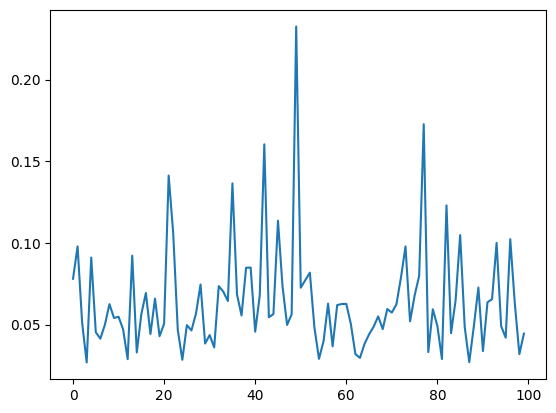

In [48]:
plt.plot(losses)

In [49]:
mlp_train_labels, mlp_train_preds = test(train_loader)
mlp_test_labels, mlp_test_preds = test(test_loader)

(0.4434458485033634,
 0.19929041763502933,
 <Axes: xlabel='Experimental order parameters', ylabel='Predicted order parameters'>,
 <matplotlib.collections.PolyCollection at 0x7f8477f11090>)

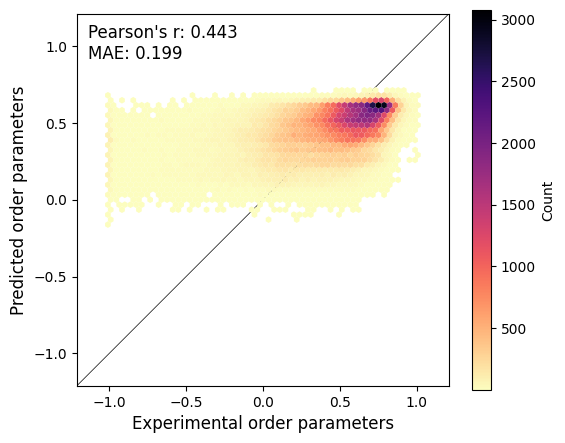

In [50]:
mlp_train_labels = torch.concatenate(mlp_train_labels).tolist()
mlp_train_preds = torch.squeeze(torch.concatenate(mlp_train_preds)).tolist()
plot_hexbin(mlp_train_labels, mlp_train_preds, cmap='magma_r')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

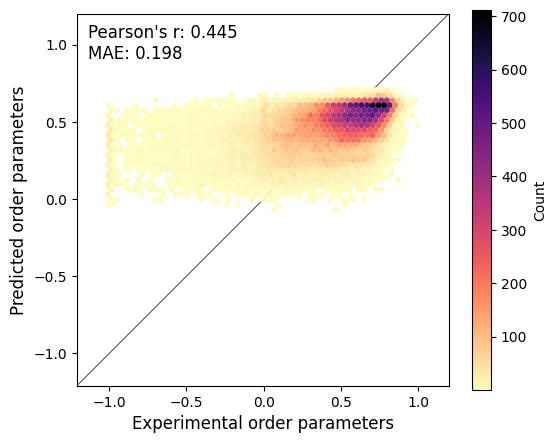

In [55]:
mlp_test_labels = torch.concatenate(mlp_test_labels).tolist()
mlp_test_preds = torch.squeeze(torch.concatenate(mlp_test_preds)).tolist()
r, mae, ax, hb = plot_hexbin(mlp_test_labels, mlp_test_preds, cmap='magma_r')
ax.figure.savefig("MLP.png",bbox_inches="tight")
files.download("MLP.png")

### GCN Model

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, MSELoss
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self,
                 num_input_features,
                 hidden_dim,
                 seed=0
                 ):
        super().__init__()
        torch.manual_seed(seed)
        self.conv1 = GCNConv(num_input_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.out = Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.out(x)

        return x

In [ ]:
input_dim = 42
hidden_dim = 32
lr = 0.01

In [ ]:
model = GCN(input_dim,hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
                        optimizer,
                        milestones=[25,50,75],
                        gamma=0.1)
criterion = MSELoss()

In [ ]:
def train(loader):
  model.train()

  for data in loader:
      data = data.to(device)
      optimizer.zero_grad()  # Clear gradients.
      out = torch.squeeze(model(data))  # Perform a forward pass
      loss = criterion(out, data.y)
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

  return loss.detach().cpu()

@torch.no_grad()
def test(loader):
    model.eval()

    labels = []
    preds = []
    for data in loader:
        data = data.to(device)
        out = model(data)
        labels.append(data.y.cpu())
        preds.append(out.cpu())
    return (labels, preds)

losses = []
for epoch in range(100):
    loss = train(train_loader)
    losses.append(loss)
    scheduler.step()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 0.0482
Epoch: 001, Loss: 0.2188
Epoch: 002, Loss: 0.0434
Epoch: 003, Loss: 0.0473
Epoch: 004, Loss: 0.0377
Epoch: 005, Loss: 0.0444
Epoch: 006, Loss: 0.0276
Epoch: 007, Loss: 0.0629
Epoch: 008, Loss: 0.1015
Epoch: 009, Loss: 0.0441
Epoch: 010, Loss: 0.0443
Epoch: 011, Loss: 0.0575
Epoch: 012, Loss: 0.0622
Epoch: 013, Loss: 0.0589
Epoch: 014, Loss: 0.0376
Epoch: 015, Loss: 0.0592
Epoch: 016, Loss: 0.1530
Epoch: 017, Loss: 0.0291
Epoch: 018, Loss: 0.0671
Epoch: 019, Loss: 0.0421
Epoch: 020, Loss: 0.0463
Epoch: 021, Loss: 0.0524
Epoch: 022, Loss: 0.0777
Epoch: 023, Loss: 0.0420
Epoch: 024, Loss: 0.0227
Epoch: 025, Loss: 0.0898
Epoch: 026, Loss: 0.0919
Epoch: 027, Loss: 0.0415
Epoch: 028, Loss: 0.0421
Epoch: 029, Loss: 0.0189
Epoch: 030, Loss: 0.0266
Epoch: 031, Loss: 0.0760
Epoch: 032, Loss: 0.0382
Epoch: 033, Loss: 0.0529
Epoch: 034, Loss: 0.0446
Epoch: 035, Loss: 0.2279
Epoch: 036, Loss: 0.1070
Epoch: 037, Loss: 0.1321
Epoch: 038, Loss: 0.0567
Epoch: 039, Loss: 0.0490


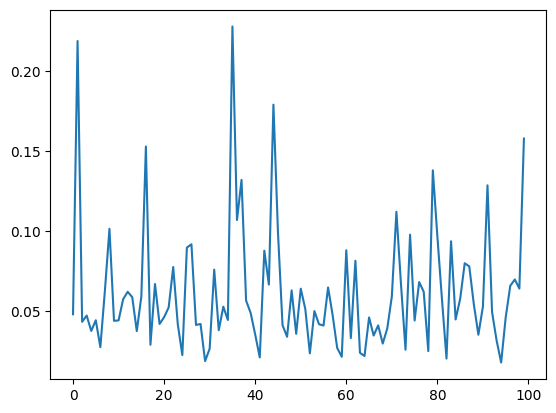

In [ ]:
plt.plot(losses)

In [ ]:
gcn_train_labels, gcn_train_preds = test(train_loader)
gcn_test_labels, gcn_test_preds = test(test_loader)

(0.5729817561175594,
 0.17823872794344484,
 <Axes: xlabel='Experimental order parameters', ylabel='Predicted order parameters'>,
 <matplotlib.collections.PolyCollection at 0x7f58e14aab90>)

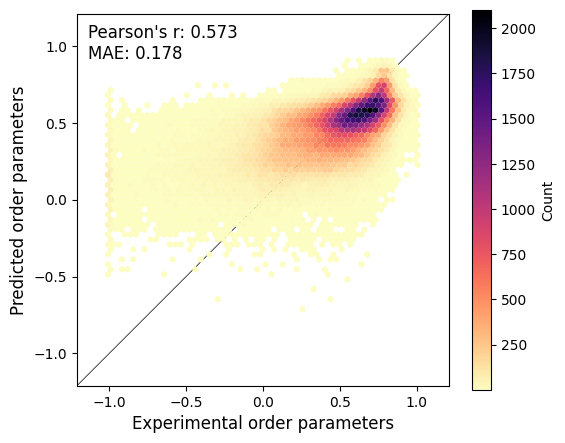

In [ ]:
gcn_train_labels = torch.concatenate(gcn_train_labels).tolist()
gcn_train_preds = torch.squeeze(torch.concatenate(gcn_train_preds)).tolist()
plot_hexbin(gcn_train_labels, gcn_train_preds, cmap='magma_r')

(0.5730644893914405,
 0.17973094678065027,
 <Axes: xlabel='Experimental order parameters', ylabel='Predicted order parameters'>,
 <matplotlib.collections.PolyCollection at 0x7f58a69fa380>)

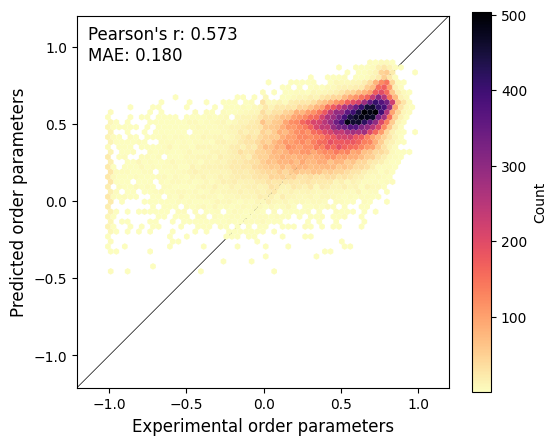

In [ ]:
gcn_test_labels = torch.concatenate(gcn_test_labels).tolist()
gcn_test_preds = torch.squeeze(torch.concatenate(gcn_test_preds)).tolist()
plot_hexbin(gcn_test_labels, gcn_test_preds, cmap='magma_r')

### GCN with TransformerConv

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, MSELoss
from torch_geometric.nn import GCNConv, TransformerConv, ResGatedGraphConv

class GraphTransformerGCN(torch.nn.Module):
    def __init__(self,
                 num_input_features,
                 hidden_dim,
                 seed=0
                 ):
        super().__init__()
        torch.manual_seed(seed)
        self.conv1 = GCNConv(num_input_features, hidden_dim)
        self.transformer_conv = TransformerConv(hidden_dim,hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.out = Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.transformer_conv(x, edge_index)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.out(x)

        return x

In [ ]:
input_dim = 42
hidden_dim = 32
lr = 0.01

In [ ]:
model = GraphTransformerGCN(input_dim,hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
                        optimizer,
                        milestones=[25,50,75],
                        gamma=0.1)
criterion = MSELoss()

In [ ]:
def train(loader):
  model.train()

  for data in loader:
      data = data.to(device)
      optimizer.zero_grad()  # Clear gradients.
      out = torch.squeeze(model(data))  # Perform a forward pass
      loss = criterion(out, data.y)
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

  return loss.detach().cpu()

@torch.no_grad()
def test(loader):
    model.eval()

    labels = []
    preds = []
    for data in loader:
        data = data.to(device)
        out = model(data)
        labels.append(data.y.cpu())
        preds.append(out.cpu())
    return (labels, preds)

losses = []
for epoch in range(100):
    loss = train(train_loader)
    losses.append(loss)
    scheduler.step()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 0.0617
Epoch: 001, Loss: 0.0769
Epoch: 002, Loss: 0.0798
Epoch: 003, Loss: 0.0512
Epoch: 004, Loss: 0.0440
Epoch: 005, Loss: 0.0822
Epoch: 006, Loss: 0.1091
Epoch: 007, Loss: 0.0289
Epoch: 008, Loss: 0.0602
Epoch: 009, Loss: 0.0304
Epoch: 010, Loss: 0.0499
Epoch: 011, Loss: 0.0506
Epoch: 012, Loss: 0.1083
Epoch: 013, Loss: 0.1096
Epoch: 014, Loss: 0.0779
Epoch: 015, Loss: 0.0858
Epoch: 016, Loss: 0.1020
Epoch: 017, Loss: 0.1659
Epoch: 018, Loss: 0.1185
Epoch: 019, Loss: 0.0460
Epoch: 020, Loss: 0.0587
Epoch: 021, Loss: 0.0392
Epoch: 022, Loss: 0.0287
Epoch: 023, Loss: 0.1302
Epoch: 024, Loss: 0.0446
Epoch: 025, Loss: 0.1631
Epoch: 026, Loss: 0.0614
Epoch: 027, Loss: 0.0172
Epoch: 028, Loss: 0.0444
Epoch: 029, Loss: 0.0835
Epoch: 030, Loss: 0.0808
Epoch: 031, Loss: 0.0355
Epoch: 032, Loss: 0.1141
Epoch: 033, Loss: 0.0254
Epoch: 034, Loss: 0.0450
Epoch: 035, Loss: 0.0623
Epoch: 036, Loss: 0.0434
Epoch: 037, Loss: 0.0546
Epoch: 038, Loss: 0.0679
Epoch: 039, Loss: 0.0327


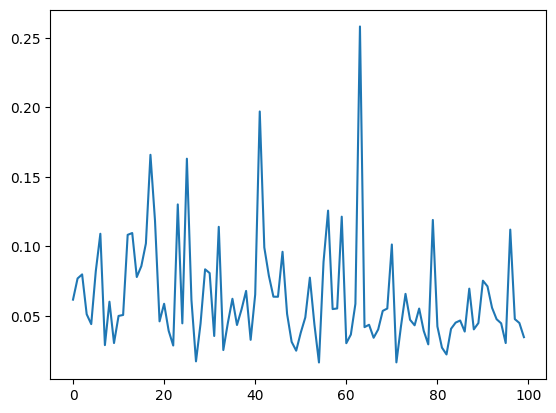

In [ ]:
plt.plot(losses)

In [ ]:
gcn_train_labels, gcn_train_preds = test(train_loader)
gcn_test_labels, gcn_test_preds = test(test_loader)

(0.5871275390625348,
 0.1756739030558637,
 <Axes: xlabel='Experimental order parameters', ylabel='Predicted order parameters'>,
 <matplotlib.collections.PolyCollection at 0x7f58723ffbe0>)

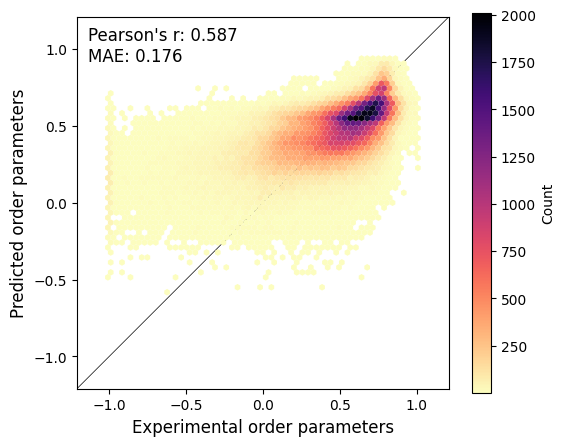

In [ ]:
gcn_train_labels = torch.concatenate(gcn_train_labels).tolist()
gcn_train_preds = torch.squeeze(torch.concatenate(gcn_train_preds)).tolist()
plot_hexbin(gcn_train_labels, gcn_train_preds, cmap='magma_r')

(0.5865150235363743,
 0.1775712831980905,
 <Axes: xlabel='Experimental order parameters', ylabel='Predicted order parameters'>,
 <matplotlib.collections.PolyCollection at 0x7f5871dd3e50>)

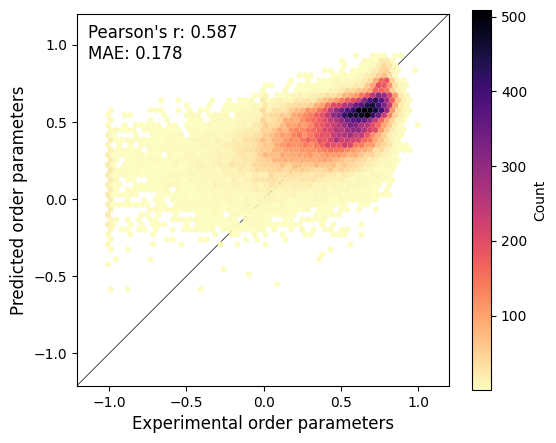

In [ ]:
gcn_test_labels = torch.concatenate(gcn_test_labels).tolist()
gcn_test_preds = torch.squeeze(torch.concatenate(gcn_test_preds)).tolist()
plot_hexbin(gcn_test_labels, gcn_test_preds, cmap='magma_r')

### GCN with TransformerConv + ResGatedGraphConv

In [56]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, MSELoss
from torch_geometric.nn import GCNConv, TransformerConv, ResGatedGraphConv

class GraphTransformerGCN(torch.nn.Module):
    def __init__(self,
                 num_input_features,
                 hidden_dim,
                 seed=0
                 ):
        super().__init__()
        torch.manual_seed(seed)
        self.conv1 = GCNConv(num_input_features, hidden_dim)
        self.transformer_conv = TransformerConv(hidden_dim,hidden_dim)
        self.res_gated_conv = ResGatedGraphConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.out = Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.transformer_conv(x, edge_index)
        x = self.res_gated_conv(x, edge_index)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.out(x)

        return x

In [57]:
input_dim = 42
hidden_dim = 32
lr = 0.01

In [58]:
model = GraphTransformerGCN(input_dim,hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
                        optimizer,
                        milestones=[25,50,75],
                        gamma=0.1)
criterion = MSELoss()

In [59]:
def train(loader):
  model.train()

  for data in loader:
      data = data.to(device)
      optimizer.zero_grad()  # Clear gradients.
      out = torch.squeeze(model(data))  # Perform a forward pass
      loss = criterion(out, data.y)
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

  return loss.detach().cpu()

@torch.no_grad()
def test(loader):
    model.eval()

    labels = []
    preds = []
    for data in loader:
        data = data.to(device)
        out = model(data)
        labels.append(data.y.cpu())
        preds.append(out.cpu())
    return (labels, preds)

losses = []
for epoch in range(100):
    loss = train(train_loader)
    losses.append(loss)
    scheduler.step()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 0.0444
Epoch: 001, Loss: 0.1099
Epoch: 002, Loss: 0.0304
Epoch: 003, Loss: 0.0749
Epoch: 004, Loss: 0.0576
Epoch: 005, Loss: 0.1106
Epoch: 006, Loss: 0.0338
Epoch: 007, Loss: 0.0470
Epoch: 008, Loss: 0.2167
Epoch: 009, Loss: 0.0444
Epoch: 010, Loss: 0.0514
Epoch: 011, Loss: 0.0528
Epoch: 012, Loss: 0.0736
Epoch: 013, Loss: 0.1103
Epoch: 014, Loss: 0.0865
Epoch: 015, Loss: 0.0438
Epoch: 016, Loss: 0.0344
Epoch: 017, Loss: 0.0342
Epoch: 018, Loss: 0.0577
Epoch: 019, Loss: 0.0794
Epoch: 020, Loss: 0.0728
Epoch: 021, Loss: 0.0782
Epoch: 022, Loss: 0.0401
Epoch: 023, Loss: 0.0299
Epoch: 024, Loss: 0.0341
Epoch: 025, Loss: 0.0472
Epoch: 026, Loss: 0.1161
Epoch: 027, Loss: 0.0317
Epoch: 028, Loss: 0.0234
Epoch: 029, Loss: 0.0813
Epoch: 030, Loss: 0.0231
Epoch: 031, Loss: 0.0316
Epoch: 032, Loss: 0.0225
Epoch: 033, Loss: 0.0371
Epoch: 034, Loss: 0.0383
Epoch: 035, Loss: 0.0569
Epoch: 036, Loss: 0.0374
Epoch: 037, Loss: 0.0777
Epoch: 038, Loss: 0.0747
Epoch: 039, Loss: 0.0414


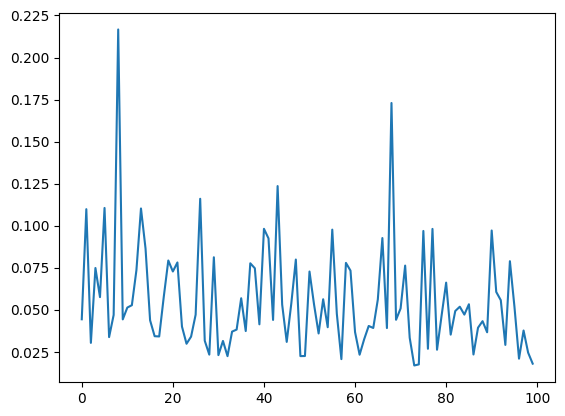

In [60]:
plt.plot(losses)

In [61]:
gcn_train_labels, gcn_train_preds = test(train_loader)
gcn_test_labels, gcn_test_preds = test(test_loader)

(0.6138612151731415,
 0.1710633733020759,
 <Axes: xlabel='Experimental order parameters', ylabel='Predicted order parameters'>,
 <matplotlib.collections.PolyCollection at 0x7f844c5dc070>)

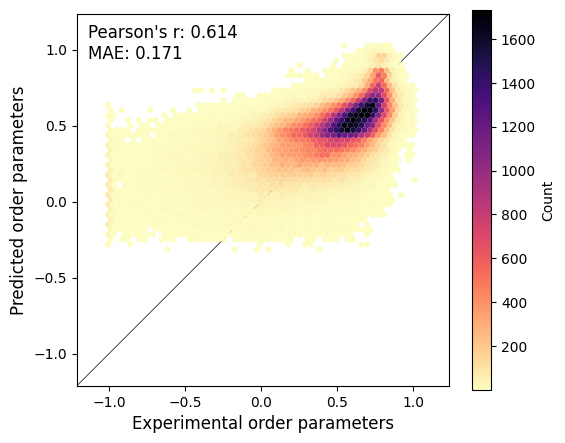

In [62]:
gcn_train_labels = torch.concatenate(gcn_train_labels).tolist()
gcn_train_preds = torch.squeeze(torch.concatenate(gcn_train_preds)).tolist()
plot_hexbin(gcn_train_labels, gcn_train_preds, cmap='magma_r')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

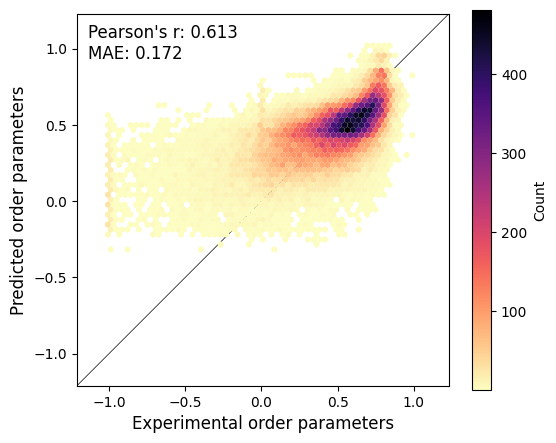

In [63]:
gcn_test_labels = torch.concatenate(gcn_test_labels).tolist()
gcn_test_preds = torch.squeeze(torch.concatenate(gcn_test_preds)).tolist()
r, mae, ax, hb = plot_hexbin(gcn_test_labels, gcn_test_preds, cmap='magma_r')
ax.figure.savefig("GCN.png",bbox_inches="tight")
files.download("GCN.png")

## EGNN

### Data

In [ ]:
class EGNNDataset(Dataset):
    def __init__(self, node_features, coords, edge_indices, labels):
        self.node_features = node_features
        self.coords = coords
        self.edge_indices = edge_indices
        self.labels = labels
        super(EGNNDataset, self).__init__()

    def len(self):
        return len(self.node_features)

    def get(self, index):
        h = torch.tensor(self.node_features[index]).to(torch.float32)   # Node features tensor for the protein graph
        coords = torch.tensor(self.coords[index]).to(torch.float32)
        edge_index = to_undirected(self.edge_indices[index])   # Edge indices tensor for the protein graph
        y = self.labels[index]  # Label tensor for the nodes in the protein graph

        x = torch.cat([h,coords],dim=1)

        data = Data(x=x, edge_index=edge_index, y=y)

        return data

In [ ]:
train_dataset = EGNNDataset(node_train, coord_train, edge_train, y_train)
val_dataset = EGNNDataset(node_val, coord_val, edge_val, y_val)
test_dataset = EGNNDataset(node_test, coord_test, edge_test, y_test)

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [ ]:
input_dim = 42
hidden_dim = 32
lr = 0.0001

In [ ]:
egnn = EGNN(in_node_nf=input_dim,
            hidden_nf=hidden_dim,
            out_node_nf=1,
            in_edge_nf=0).to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
                        optimizer,
                        milestones=[25,50,75],
                        gamma=0.1)
criterion = MSELoss()

In [ ]:
def train(loader):
  egnn.train()

  for data in loader:
      data = data.to(device)
      optimizer.zero_grad()  # Clear gradients.
      out, _ = egnn(h = data.x[:,:42],
                 x = data.x[:,42:],
                                edges = data.edge_index,
                                edge_attr = None
                                )  # Perform a forward pass
      out = torch.squeeze(out)
      loss = criterion(out, data.y)
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

  return loss.detach().cpu()

@torch.no_grad()
def test(loader):
    egnn.eval()

    labels = []
    preds = []
    for data in loader:
        data = data.to(device)
        out, _ = egnn(h = data.x[:,:42],
                   x = data.x[:,42:],
                   edges = data.edge_index,
                   edge_attr = None)
        labels.append(data.y.cpu())
        preds.append(out.cpu())
    return (labels, preds)

losses = []
for epoch in range(100):
    loss = train(train_loader)
    losses.append(loss)
    optimizer.step()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<ipython-input-575-9705d9951ac3>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords = torch.tensor(self.coords[index]).to(torch.float32)


Epoch: 000, Loss: 1.4579
Epoch: 001, Loss: 1.7191
Epoch: 002, Loss: 1.5941
Epoch: 003, Loss: 1.5205
Epoch: 004, Loss: 1.9376
Epoch: 005, Loss: 1.7888
Epoch: 006, Loss: 1.5164
Epoch: 007, Loss: 1.5640
Epoch: 008, Loss: 1.4247
Epoch: 009, Loss: 1.4492
Epoch: 010, Loss: 1.6159
Epoch: 011, Loss: 1.4957
Epoch: 012, Loss: 1.5064
Epoch: 013, Loss: 1.6116
Epoch: 014, Loss: 1.6225
Epoch: 015, Loss: 1.6940
Epoch: 016, Loss: 1.6283
Epoch: 017, Loss: 1.4240
Epoch: 018, Loss: 1.4270
Epoch: 019, Loss: 1.2221
Epoch: 020, Loss: 1.6022
Epoch: 021, Loss: 1.4049
Epoch: 022, Loss: 1.7602
Epoch: 023, Loss: 1.5022
Epoch: 024, Loss: 1.5493
Epoch: 025, Loss: 1.5157
Epoch: 026, Loss: 1.6475
Epoch: 027, Loss: 1.4684
Epoch: 028, Loss: 1.4799
Epoch: 029, Loss: 1.6485
Epoch: 030, Loss: 1.4372
Epoch: 031, Loss: 1.3915
Epoch: 032, Loss: 1.2620
Epoch: 033, Loss: 1.6984
Epoch: 034, Loss: 1.6544
Epoch: 035, Loss: 1.6101
Epoch: 036, Loss: 1.5212
Epoch: 037, Loss: 1.5157
Epoch: 038, Loss: 1.2996
Epoch: 039, Loss: 1.5707


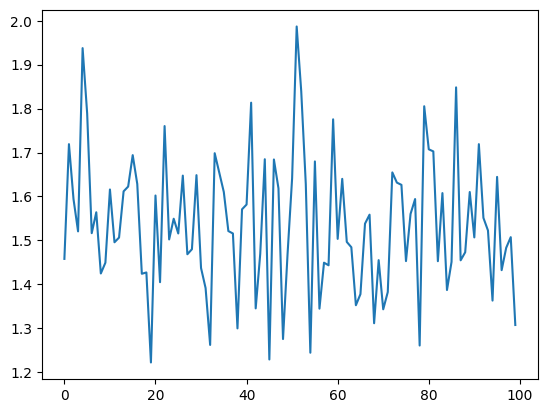

In [ ]:
plt.plot(losses)

In [ ]:
egnn_train_labels, egnn_train_preds = test(train_loader)
egnn_test_labels, egnn_test_preds = test(test_loader)

<ipython-input-575-9705d9951ac3>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords = torch.tensor(self.coords[index]).to(torch.float32)


(0.28561750970014044,
 0.864018496674248,
 <Axes: xlabel='Experimental order parameters', ylabel='Predicted order parameters'>,
 <matplotlib.collections.PolyCollection at 0x7fab264ffee0>)

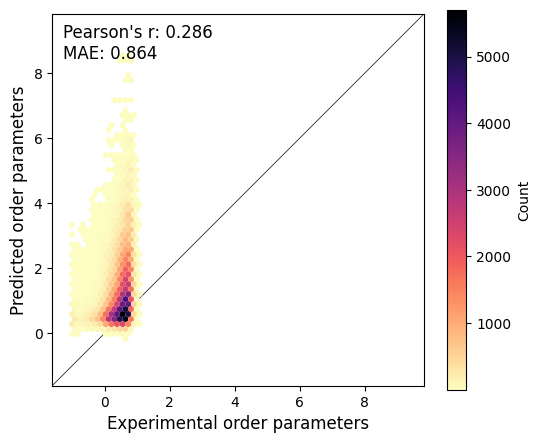

In [ ]:
egnn_train_labels = torch.concatenate(egnn_train_labels).tolist()
egnn_train_preds = torch.squeeze(torch.concatenate(egnn_train_preds)).tolist()
plot_hexbin(egnn_train_labels, egnn_train_preds, cmap='magma_r')

(0.29137134001632436,
 0.8916083838192997,
 <Axes: xlabel='Experimental order parameters', ylabel='Predicted order parameters'>,
 <matplotlib.collections.PolyCollection at 0x7fab260ea8f0>)

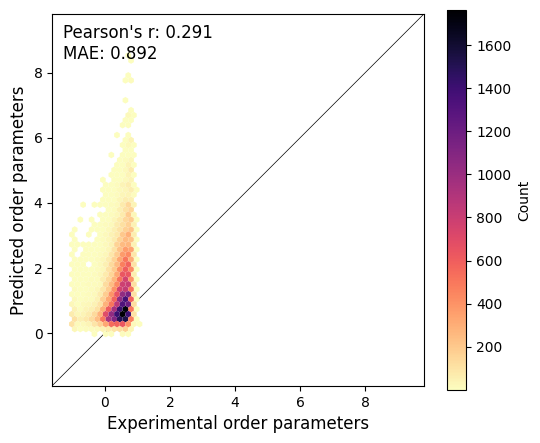

In [ ]:
egnn_test_labels = torch.concatenate(egnn_test_labels).tolist()
egnn_test_preds = torch.squeeze(torch.concatenate(egnn_test_preds)).tolist()
plot_hexbin(egnn_test_labels, egnn_test_preds, cmap='magma_r')